In [408]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

## Redução de dimensionalidade
#### Utilizando PCA

##### A escolha do PCA (Principal Component Analysis) para reduzir a dimensionalidade dos dados é motivada pela sua eficácia em preservar a variância original dos dados enquanto reduz o número de dimensões. O PCA identifica os eixos no espaço de dados que maximizam a variância e projeta os dados nesses eixos. Isso não apenas ajuda a reduzir a complexidade computacional e o ruído, mas também facilita a visualização e a interpretação dos dados, mantendo a estrutura e as relações intrínsecas entre as variáveis.

In [409]:

# função para aplicar PCA e plotar os pontos no 2D, sendo os eixos os dois componentes principais
def apply_and_plot_pca(df, class_column, labels):

    #filtrar o DataFrame para conter apenas as linhas com labels das duas classes desejadas
    df = df[df[class_column].isin([labels[0], labels[1]])]
    
    #armazenar os labels e remover a coluna de labels do DataFrame, para que não seja incluída no PCA
    labels_column = df[class_column]
    df = df.drop(columns=[class_column])

    #aplicar PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)

    #criar um novo DataFrame só com os dois componentes principais
    pca_df = pd.DataFrame(components, columns=['x', 'y'])
    pca_df[class_column] = labels_column.values

    #mapear os pontos de cada classe para uma cor diferente
    colors = {labels[0]: 'red', labels[1]: 'blue'}
    label_colors = labels_column.map(colors)

    #plotar o gráfico de dispersão
    plt.scatter(pca_df['x'], pca_df['y'], c=label_colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Dataset')

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=labels[0]),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=labels[1])],
               loc='upper right')
    plt.show()

    
    return pca_df



## Exemplo inicial e criação do classificador



## Iris

##### Ao longo da construção do classificador será utilizado o dataset Iris, com as duas classes sendo as espécies Iris-setosa e Iris-versicolor. O dataset é composto por 150 amostras, com 4 atributos cada. Será útil para a visualização dos resultados intermediários do classificador.


In [410]:
# Exemplo de uso com o dataset Iris
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
iris_df.head()

class_column = 'species'
labels = ['setosa', 'versicolor']


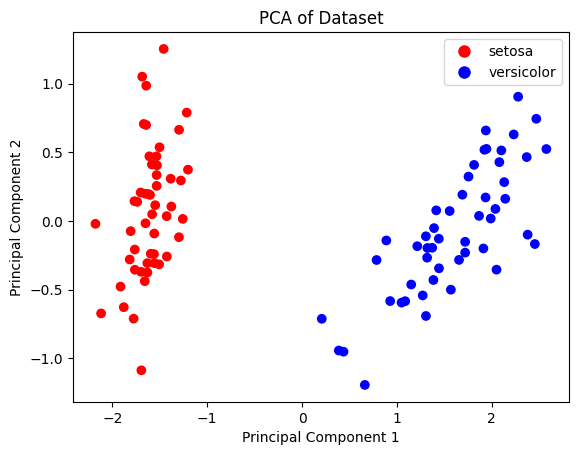

In [411]:
pca_df = apply_and_plot_pca(iris_df, class_column, labels)

### Separação dos dados em treino e teste

In [412]:
from sklearn.model_selection import train_test_split

# Dividindo o DataFrame em treino e teste
train_df, test_df = train_test_split(pca_df, test_size=0.3, random_state=30)

# Verificando os tamanhos dos conjuntos
print("Tamanho do conjunto de treino:", len(train_df))
print("Tamanho do conjunto de teste:", len(test_df))

print(train_df.head())

Tamanho do conjunto de treino: 70
Tamanho do conjunto de teste: 30
           x         y     species
95  1.392548 -0.051616  versicolor
32 -1.670216  0.706417      setosa
63  2.040115  0.087959  versicolor
69  1.151803 -0.462055  versicolor
29 -1.557562 -0.306426      setosa


In [413]:
print(test_df.head())

           x         y     species
20 -1.278599  0.295007      setosa
91  1.936080  0.171507  versicolor
34 -1.562699 -0.240627      setosa
52  2.471603  0.743956  versicolor
8  -1.777007 -0.710388      setosa


# Envoltória Convexa
Computação da Envolória Convexa utilizando a Varredura de Graham

In [414]:
#função para calcular posição relativa entre pontos
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

#função para calcular ângulo polar entre dois pontos
def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

#função para calcular distância entre dois pontos
def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

#função para calcular a envoltória convexa de um conjunto de pontos
def graham_scan(points):
    n = len(points)

    #ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  #troca o ponto inicial com o primeiro ponto

    #ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) #ordena por ângulo polar e depois por distância em caso de empate

    #inicializa a pilha de pontos
    stack = [pivot, sorted_points[0], sorted_points[1]]

    #processamento
    for point in sorted_points[2:]:
        #enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) !=2:
            stack.pop()
        stack.append(point)
    
    return stack


# Interseção 
##### Checar se as classes são linearmente separáveis, para assim poder gerar um hiperplano que as separe e classifique corretamente

Essa verificação será feita utilizando o algoritmo de varredura linear, que consiste em verificar interseções entre os segmentos de reta formados por pares de pontos de cada envoltória convexa. Caso haja interseção, as classes não são linearmente separáveis.

In [415]:
#função para verificar se dois segmentos se interceptam
def doIntersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False

#função para dividir os pontos do dataset entre as duas classes
def divide_points(pca_df, class_column, labels):

    #separar os pontos de cada classe em arrays
    class1_points = pca_df[pca_df[class_column] == labels[0]][['x', 'y']].values
    class2_points = pca_df[pca_df[class_column] == labels[1]][['x', 'y']].values

    #calcular a envoltória convexa de cada classe
    hull_class1 = graham_scan(class1_points.tolist())
    hull_class2 = graham_scan(class2_points.tolist())

    return class1_points, class2_points, hull_class1, hull_class2        


In [416]:
%pip install sortedcontainers
from sortedcontainers import SortedList

class LineSegment:
    def __init__(self, start, end, hull_type):
        self.start = min(start, end, key=lambda p: (p[0], p[1]))
        self.end = max(start, end, key=lambda p: (p[0], p[1]))
        self.hull_type = hull_type

# Função para criar eventos a partir dos pontos da casca
def create_events(hull, hull_type):
    # Criando segmentos de linha a partir dos pontos adjacentes da casca
    return [LineSegment(hull[i], hull[i + 1], hull_type) for i in range(len(hull) - 1)]

# Função para processar cada evento
def process_event(segment, current_segments, idx):
    # Lógica para verificar a interseção com segmentos acima e abaixo

    # Se o segmento intersecta com o segmento abaixo e eles não pertencem à mesma envoltória
    if idx > 0 and doIntersect(segment.start, segment.end, current_segments[idx - 1].start, current_segments[idx - 1].end) and segment.hull_type != current_segments[idx - 1].hull_type:
        return False
    
    # Se o segmento intersecta com o segmento acima e eles não pertencem à mesma envoltória
    if idx < len(current_segments) and doIntersect(segment.start, segment.end, current_segments[idx].start, current_segments[idx].end) and segment.hull_type != current_segments[idx].hull_type:
        return False

    return True  # Retorna verdadeiro se não houver interseção

# Função principal para verificar a separabilidade
def check_separability_linear_scan(hull1, hull2):
    # Criando uma lista de segmentos com eventos associados
    segments = create_events(hull1, 'hull1') + create_events(hull2, 'hull2')
    
    # Ordenando os eventos pela coordenada x do ponto inicial de cada segmento
    segments.sort(key=lambda segment: segment.start[0])

    # Usando SortedList para manter a ordem dos segmentos com base em suas coordenadas y
    current_segments = SortedList(key=lambda segment: (segment.start[1] + segment.end[1]) / 2)

    # Processando cada segmento
    for segment in segments:
        idx = current_segments.bisect(segment)  # Obtendo o índice onde o segmento será inserido

        # Verificando se o evento atual intersecta com outros segmentos
        if process_event(segment, current_segments, idx) is False:
            return False 

        # Adiciona e remove segmentos na lista ativa com base na coordenada x ordenada
        if segment in current_segments:
            current_segments.remove(segment)
        else:
            current_segments.add(segment) 
            
    return True  

Note: you may need to restart the kernel to use updated packages.


Verificação de interseção entre dois segmentos de reta no dataset Iris:

In [417]:

class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)
check_separability_linear_scan(hull_class1, hull_class2)


True

Plot das envoltórias convexas do dataset Iris:

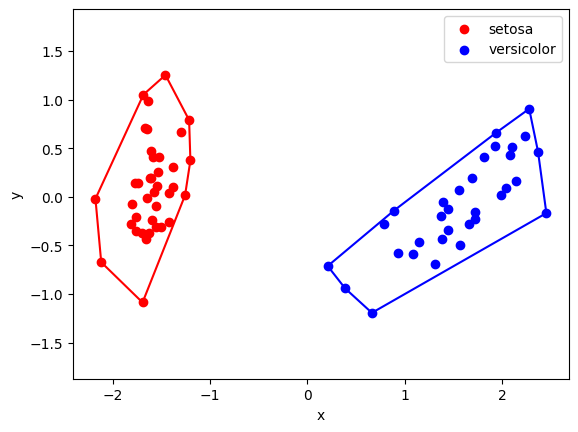

In [418]:
#plot envoltórias convexas
def plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels):
    plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
    plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

    hull_class1 = np.vstack((hull_class1, hull_class1[0]))
    hull_class2 = np.vstack((hull_class2, hull_class2[0]))

    plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
    plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')


    plt.xlabel(pca_df.columns[0])
    plt.ylabel(pca_df.columns[1])
    plt.legend()
    plt.axis('equal')



plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)


# Ponto mais próximo

Para verificar a menor distância entre as envoltórias, iremos considerar tanto o ponto mais próximo de uma envoltória em relação a outra, quanto o ponto mais próximo de uma envoltória em relação a um segmento de reta da outra envoltória. Esse segundo caso será analisado por meio da projeção do ponto sobre o segmento de reta.

In [419]:

# função para calcular a distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# função para calcular a distância de um ponto até um segmento de reta
def point_to_segment_distance(p, a, b):

    #vetorizando os pontos
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    #calculando os vetores
    ap = p - a
    ab = b - a
    
    #calculando o produto escalar
    dot_product = np.dot(ap, ab) / np.dot(ab, ab)
    
    #evitando que o ponto de projeção saia do segmento de linha
    dot_product = np.clip(dot_product, 0, 1)
    
    #calculando o ponto de projeção no segmento de linha
    projection = a + dot_product * ab
    
    #retornando a distancia euclidiana entre o ponto e a projeção dele no segmento
    return euclidean_distance(p, projection), projection


# função para plotar as envoltórias convexas e o segmento de menor distância entre elas
def plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels):
    
    plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)

    # Plotar a menor distância
    plt.plot(*closest_pair[0], 'go')  # ponto ou projeção na envoltória 1
    plt.plot(*closest_pair[1], 'go')  # ponto ou projeção na envoltória 2
    plt.plot([closest_pair[0][0], closest_pair[1][0]], 
            [closest_pair[0][1], closest_pair[1][1]], 'g-')  # linha representando a menor distância
    
    

# função para calcular o par de pontos mais próximos entre as duas classes, que geram o menor segmento entre as duas envoltórias convexas
def min_hulls_distance(hull_class1, hull_class2):
    
    min_distance = float('inf') # menor distância entre as envoltórias convexas, inicializada com infinito
    closest_pair = (None, None) # par de pontos mais próximos entre as duas envoltórias convexas, inicializados com None

    # distância entre pontos de cada envoltória
    for p1 in hull_class1:
        for p2 in hull_class2:
            distance = euclidean_distance(p1, p2)
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, p2)

    # distância entre a projecao de cada ponto de uma classe no segmento formado por dois pontos da outra classe
    for i in range(len(hull_class1) - 1): #projecao dos pontos da classe 2 no segmento formado por dois pontos da classe 1
        for p2 in hull_class2:
            distance, projection = point_to_segment_distance(p2, hull_class1[i], hull_class1[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (projection, p2)

    for i in range(len(hull_class2) - 1): #projecao dos pontos da classe 1 no segmento formado por dois pontos da classe 2
        for p1 in hull_class1:
            distance, projection = point_to_segment_distance(p1, hull_class2[i], hull_class2[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, projection)

    #ao final destes loops, o par de pontos mais próximos entre as duas envoltórias convexas estará armazenado na variável closest_pair

    return closest_pair


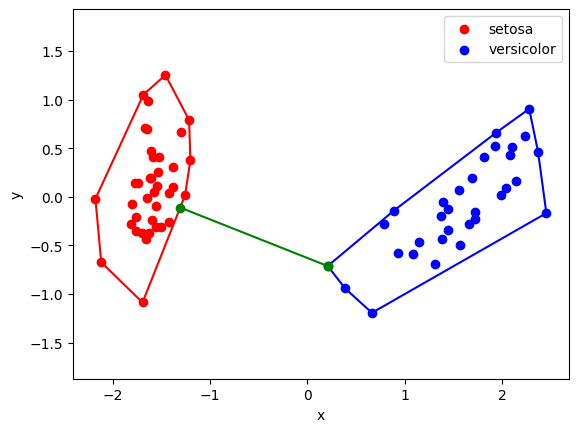

In [420]:
closest_pair = min_hulls_distance(hull_class1, hull_class2)

plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

# Linha perpendicular de separação

Para computar a linha perpendicular que separa, será levada em consideração a menor distância entre as envoltórias, calculada anteriormente. A linha será traçada no ponto médio entre os dois pontos mais próximos, e terá como vetor diretor o vetor perpendicular ao segmento de reta formado pelos dois pontos mais próximos.

In [421]:
#função para calcular a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def compute_perpendicular_line(p1, p2, print_equation=True):

    #calcular a inclinação da reta que passa pelos dois pontos
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

        #calcular a inclinação da reta perpendicular - será o negativo do inverso da inclinação da reta que passa pelos dois pontos
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = 0 #reta horizontal
    else:
        perp_slope = float('inf') #reta vertical

    #calcular o ponto médio do segmento
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    #calcular o coeficiente linear da reta perpendicular
    y_intercept = midpoint[1] - perp_slope * midpoint[0]

    # printa a equação da reta perpendicular
    if print_equation:
        print()
        print("Equação da reta perpendicular: y = {}x + {}".format(perp_slope, y_intercept))

    #retornar a inclinação, o coeficiente linear e o ponto médio da reta perpendicular
    return perp_slope, y_intercept, midpoint

#função para plotar a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin):

    plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

    #ajustar o tamanho da reta perpendicular para que ela seja visível no gráfico
    if abs(perp_slope) != float('inf'):
        x = np.linspace(midpoint[0] - margin, midpoint[0] + margin, 400)
        y = perp_slope * x + y_intercept
        plt.plot(x, y, 'm-')
    else:
        plt.axvline(x=midpoint[0], color='m', linestyle='-')

    #setar os limites do gráfico para que a reta perpendicular seja o foco
    plt.xlim(midpoint[0] - margin, midpoint[0] + margin)
    plt.ylim(midpoint[1] - margin, midpoint[1] + margin)

    plt.axis('equal')


Equação da reta perpendicular: y = 2.5216633781319784x + 0.9766031394379153


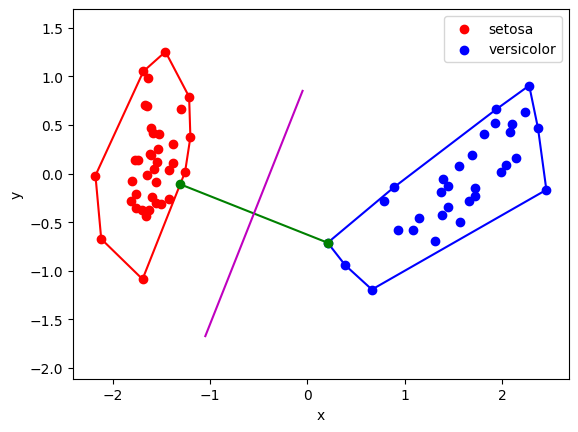

In [422]:
perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, 0.5)

## Verificar à qual classe um novo ponto pertence

Para verificar à qual classe um novo ponto pertence, será computada a distância entre o ponto e a linha perpendicular de separação. Caso a distância seja positiva, o ponto pertence à classe da envoltória convexa que está acima da linha. Caso a distância seja negativa, o ponto pertence à classe da envoltória convexa que está abaixo da linha.

In [423]:
#função para calcular a equação da reta perpendicular que passa pelo ponto médio
def perpendicular_line_equation(closest_pair):
    
    perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1], False)

    A = -perp_slope
    B = 1
    C = perp_slope * midpoint[0] - midpoint[1]

    line_coeficients = [A, B, C]
    return line_coeficients
    

def class_position(labels, closest_pair, line_coeficients):

    A, B, C = line_coeficients

    value = A * closest_pair[0][0] + B * closest_pair[0][1] + C # valor da equação da reta perpendicular no ponto mais próximo da classe 1

    # Caso o valor seja positivo, a classe 1 está acima da reta perpendicular
    if value > 0:
        class_above = labels[0]
        class_below = labels[1]
        return class_above, class_below
    elif value < 0:
        class_above = labels[1]
        class_below = labels[0]
        return class_above, class_below


def determine_class(class_above, class_below, point, line_coeficients):

    if len(line_coeficients) != 3:
        raise ValueError(f"Expected 3 coefficients, but got {len(line_coeficients)}: {line_coeficients}")
    A, B, C = line_coeficients

    #Determina a qual classe o ponto pertence

    value = A * point[0] + B * point[1] + C
    
    if value > 0:
        return class_above
    elif value < 0:
        return class_below
    else:
        return None
   

# plota os as envoltórias convexas, o segmento de menor distância entre elas, a reta perpendicular e o ponto de teste
def plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin):
    
    plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin)

    plt.plot(test_point[0], test_point[1], 'o', color='magenta', label='Test Point')
   
    plt.legend()
    plt.axis('equal')
    plt.show()



O ponto de teste pertence à classe: versicolor


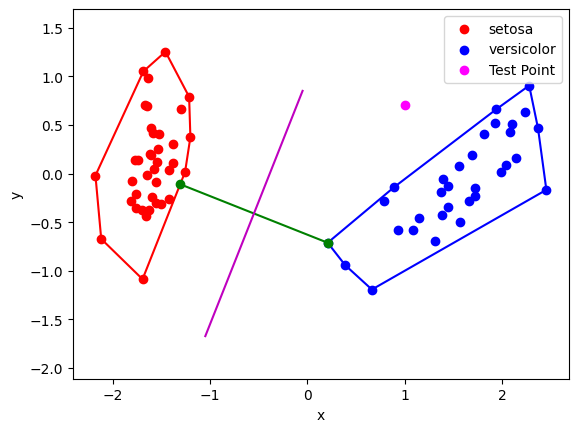

In [424]:
# Exemplo de uso:
line_coeficients = perpendicular_line_equation(closest_pair)
test_point = [1, 0.7]
class_above, class_below = class_position(labels, closest_pair, line_coeficients)
predicted_class = determine_class(class_above, class_below, test_point, line_coeficients)
print(f"O ponto de teste pertence à classe: {predicted_class}")
plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, 0.5)



### Predição de classe no dataset de teste

Para cada ponto do dataset de teste, será predita a classe à qual ele pertence, utilizando o modelo treinado. Em seguida, serão computadas as métricas de precisão, revocação e f1-score.

In [425]:
line_coeficients = perpendicular_line_equation(closest_pair)
class_above, class_below = class_position(labels, closest_pair, line_coeficients)

#função para prever as classes de um conjunto de pontos, baseando na sua posição em relação à reta perpendicular
def predict_classes(df, line_coeficients, class_above, class_below):

   #Aplica a função determine_class para cada ponto do dataset e armazena o resultado na coluna 'Predicted Class'
   df['Predicted Class'] = df.apply(lambda row: determine_class(class_above, class_below, [row['x'], row['y']], line_coeficients), axis=1)

   print(df.head())
   return df

predicted_df = predict_classes(test_df, line_coeficients, class_above, class_below)




           x         y     species Predicted Class
20 -1.278599  0.295007      setosa          setosa
91  1.936080  0.171507  versicolor      versicolor
34 -1.562699 -0.240627      setosa          setosa
52  2.471603  0.743956  versicolor      versicolor
8  -1.777007 -0.710388      setosa          setosa


### Métricas: Precisão, Revocação e F1-Score

Para calcular as métricas, serão utilizadas funções do sklearn.metrics, comparando os valores preditos com os valores reais.

In [426]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(predicted_df, class_column, labels):
    #obter os valores verdadeiros e os valores previstos
    y_true = predicted_df[class_column].values
    y_pred = predicted_df['Predicted Class'].values

    #calcular precisão, recall e F1-score
    precision = precision_score(y_true, y_pred, average='macro')  
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print()
    print("Model Metrics:")
    print()
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()
   
    
    #calcular precisão, recall e F1-score para cada classe
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

   
    #imprimir as métricas para cada classe
    for label, p, r, f1 in zip(labels, precision_per_class, recall_per_class, f1_per_class):
        print("-" * 30)
        print()
        print(f"Metrics of Class: {label}")
        print()
        print(f"Precision: {p:.4f}")
        print(f"Recall: {r:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print()


Métricas para o dataset Iris:

In [427]:
metrics(predicted_df, class_column)

TypeError: metrics() missing 1 required positional argument: 'labels'

# Experimentos com dados reais

Para facilitar o experimento com os outros datasets, será criada a função '''test_dataset''', que recebe como parâmetro a classe a ser prevista, os rótulos das classes e o dataset. A função é responsável por chamar as funções de treino e teste, e imprimir as métricas de precisão, revocação e f1-score.

In [ ]:
def test_dataset(class_column, labels, df, margin):

    print("Classes:", labels)

    #verificando se há pontos suficientes para calcular a envoltória convexa em cada label
    if len(df[df[class_column] == labels[0]]) < 3 or len(df[df[class_column] == labels[1]]) < 3:
        print("Não há pontos suficientes para calcular a envoltória convexa em cada classe.")
        return

    #aplicando o PCA e plota os pontos no 2D, sendo os eixos os dois componentes principais
    pca_df = apply_and_plot_pca(df, class_column, labels)

   
    #dividindo o DataFrame em treino e teste
    train_df, test_df = train_test_split(pca_df, test_size=0.3, random_state=42)


    #dividindo os pontos do dataset entre as duas classes e calculando a envoltória convexa de cada classe
    class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)

    #checando se as classes são separáveis linearmente, se não forem, o programa é "encerrado"
    if check_separability_linear_scan(hull_class1, hull_class2):

        print("As classes são separáveis linearmente.")
        

        #encontrando o par de pontos mais próximos entre as duas envoltórias convexas
        closest_pair = min_hulls_distance(hull_class1, hull_class2)

        #calculando a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
        perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

        #calculando a equação da reta perpendicular que passa pelo ponto médio
        line_coeficients = perpendicular_line_equation(closest_pair)

        #determinando a posição das classes em relação à reta perpendicular
        class_above, class_below = class_position(labels, closest_pair, line_coeficients)

        #plotando as envoltórias convexas, o segmento de menor distância entre elas e a reta perpendicular
        plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin)
        plt.show()
        
        #classificando os pontos do conjunto de teste de acordo com a sua posição em relação à reta perpendicular
        predicted_df = predict_classes(test_df, line_coeficients, class_above, class_below)

        #calculando as métricas da classificação
        metrics(predicted_df, class_column, labels)
      
    else:
        print("As classes não são separáveis linearmente.")

        


Dado que são necessários 10 datasets para avaliar o desempenho do classificador, e já avaliamos o desempenho para o dataset Iris, em seguida estão os resultados para os outros 9 datasets.

# Olivetti Faces

O dataset Olivetti Faces é composto por 400 imagens de 40 pessoas diferentes, com 10 imagens por pessoa. Cada imagem possui 64x64 pixels, totalizando 4096 atributos. Será utilizado para testar o desempenho do classificador em um dataset com alta dimensionalidade. Escolhemos os rótulos 0 e 1 para a classe 'target'.

In [ ]:
# olivetti faces
from sklearn.datasets import fetch_olivetti_faces

# Carregar o dataset e visualizar
faces = fetch_olivetti_faces()
faces_df = pd.DataFrame(faces.data)
faces_df['target'] = faces.target
faces_df['target'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

Classes: [0, 1]


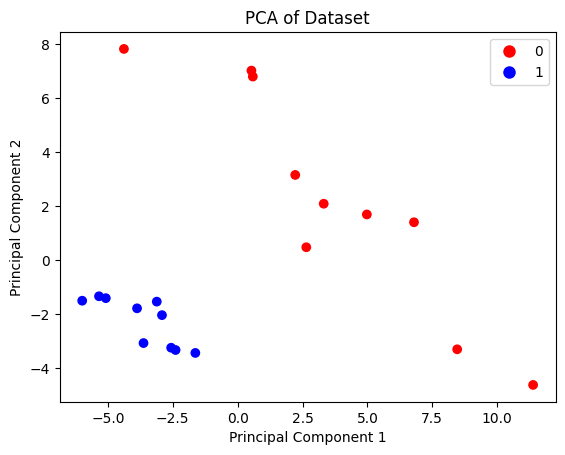

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -1.2772498306178441x + -0.8224539098904222


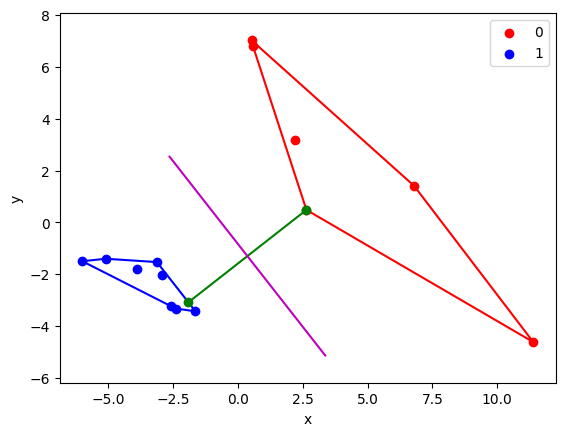

           x         y  target  Predicted Class
0   3.317022  2.094107       0                0
17 -3.627635 -3.059815       1                1
15 -5.342383 -1.328431       1                1
1  -4.382298  7.819897       0                0
8   4.979135  1.697153       0                0

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 0

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, faces_df, 3)

# Digits

O dataset Digits é composto por 1797 imagens de dígitos escritos à mão, com 8x8 pixels cada, totalizando 64 atributos. Será utilizado para testar o desempenho do classificador em um dataset com baixa dimensionalidade. Escolhemos os rótulos 0 e 1 para a classe 'target'.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
df = pd.DataFrame(digits.data)
df['target'] = digits.target
df['target'].unique()


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Classes: [0, 1]


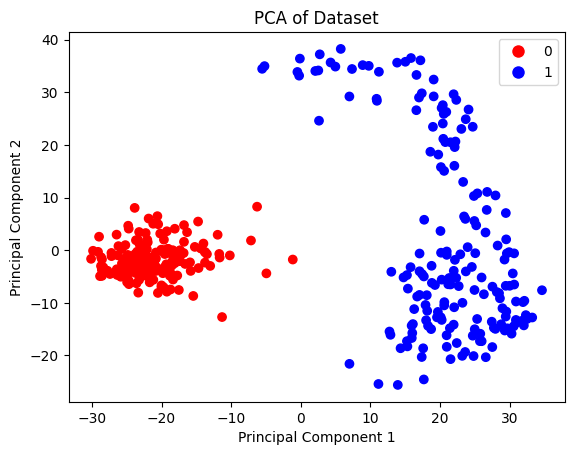

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -4.470272015555995x + 1.4215267460194658


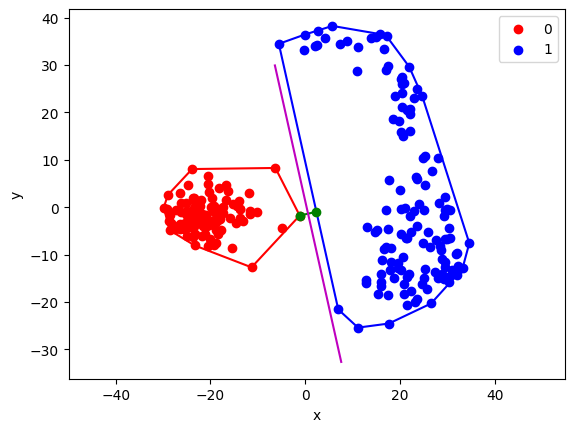

             x          y  target  Predicted Class
224  30.930202  -9.747099       1                1
42  -13.474418  -0.734843       0                0
285 -21.181781  -2.441898       0                0
302   6.994090  29.222559       1                1
56  -20.886410  -3.000853       0                0

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 0

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, df, 7)

# Coil 2000

O dataset CoIL 2000, usado no desafio Insurance Company Benchmark (COIL 2000) contém informações sobre clientes de uma seguradora. Os dados consistem em 86 variáveis ​​e incluem dados de uso de produtos e dados sociodemográficos. Será utilizado para testar o desempenho do classificador em um dataset com alta dimensionalidade. Escolhemos os rótulos 1 e 18 para a classe 'MOSTYPE'.

In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/coil2000.csv"
df = pd.read_csv(url)

df['MOSTYPE'].unique()

array([33, 37,  9, 40, 23, 39, 11, 10, 41, 38, 22, 13, 31, 34, 24,  8,  7,
        3, 36, 25, 20, 12, 35, 30, 29, 32,  1, 26,  2,  4, 16,  5, 21,  6,
       18, 27, 28, 17, 15, 19])

Classes: [1, 18]


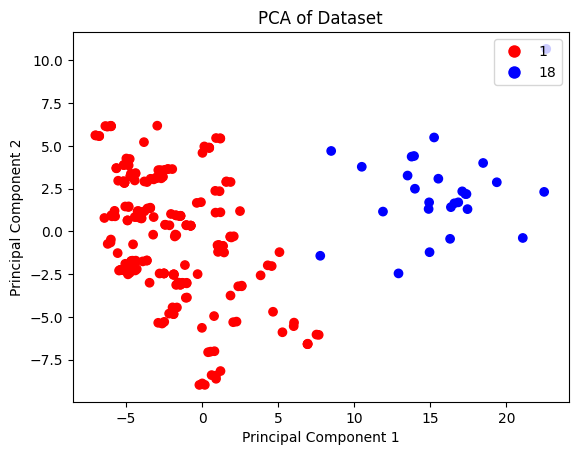

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -1.7742861881459477x + 13.655429051127964


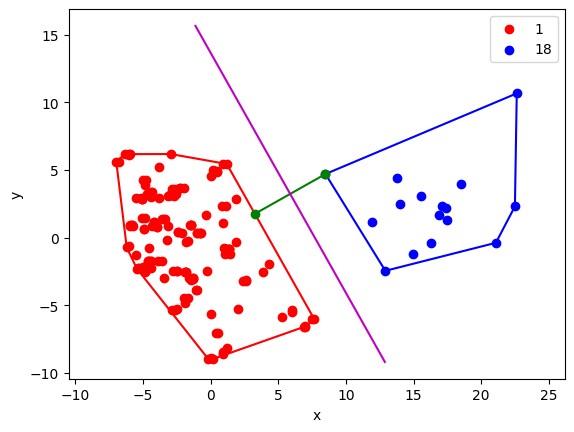

             x         y  MOSTYPE  Predicted Class
24   13.936750  4.404201       18               18
6     1.374511 -0.843027        1                1
153   1.195845  5.421415        1                1
212  -5.849486  0.915841        1                1
199  -4.842066  1.425125        1                1

Model Metrics:

Precision: 0.9922
Recall: 0.9545
F1-Score: 0.9723

------------------------------

Metrics of Class: 1

Precision: 0.9844
Recall: 1.0000
F1-Score: 0.9921

------------------------------

Metrics of Class: 18

Precision: 1.0000
Recall: 0.9091
F1-Score: 0.9524



In [ ]:
class_column = 'MOSTYPE'

labels = [1, 18]

test_dataset(class_column, labels, df, 7)

# Dermatology

In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/dermatology.csv"
df = pd.read_csv(url)

df['Class'].unique()

array([2, 1, 3, 5, 4, 6])

Classes: [1, 4]


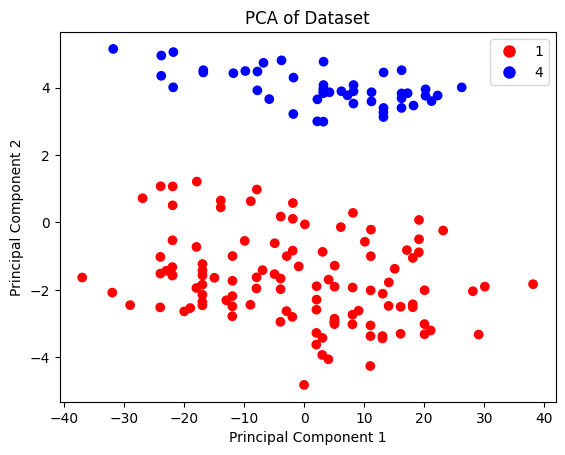

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -0.03534910289048279x + 1.8286738804131826


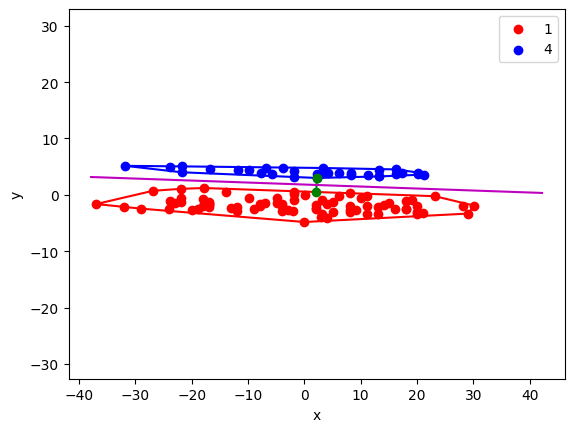

             x         y  Class  Predicted Class
78  -11.925438 -2.486317      1                1
155  14.081102 -2.473858      1                1
128 -11.894205 -0.995579      1                1
55   -7.844592  0.978106      1                1
94   11.031648 -4.254947      1                1

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 4

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'Class'

labels = [1, 4]

test_dataset(class_column, labels, df, 40)

# Glass

In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/glass.csv"
df = pd.read_csv(url)

df['TypeGlass'].unique()

array([1, 2, 3, 5, 6, 7])

Classes: [1, 5]


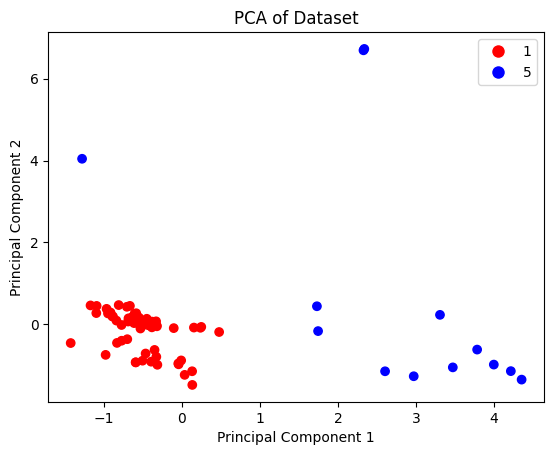

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -1.3930950315873203x + 1.2731031040320824


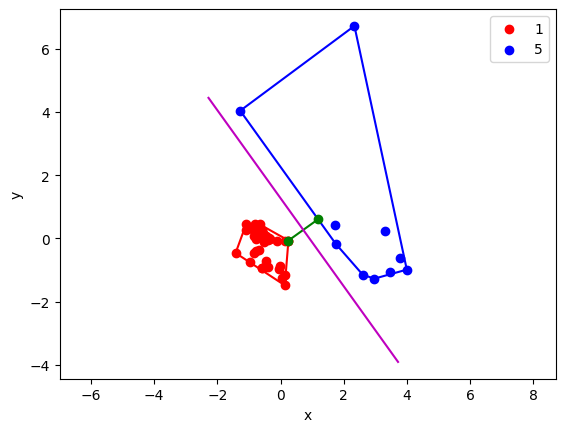

           x         y  TypeGlass  Predicted Class
30 -0.040741 -0.979268          1                1
0  -0.703388  0.426293          1                1
22 -0.383356 -0.076412          1                1
31 -0.881667  0.189720          1                1
18 -0.963250  0.376049          1                1

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 5

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'TypeGlass'

labels = [1, 5]

test_dataset(class_column, labels, df, 3)

# Letter

In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/letter.csv"
df = pd.read_csv(url)

df['Class'].unique()

array(['Z', 'P', 'S', 'H', 'F', 'N', 'R', 'M', 'D', 'V', 'A', 'K', 'E',
       'O', 'Q', 'L', 'X', 'Y', 'I', 'W', 'U', 'T', 'C', 'G', 'B', 'J'],
      dtype=object)

Classes: ['M', 'Z']


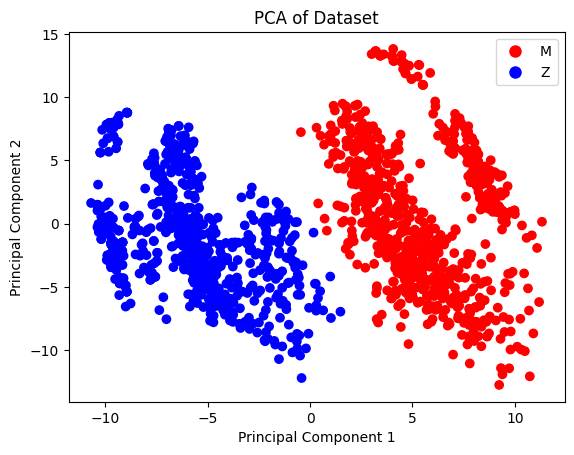

As classes são separáveis linearmente.

Equação da reta perpendicular: y = -3.143728964080946x + 1.2237161322103258


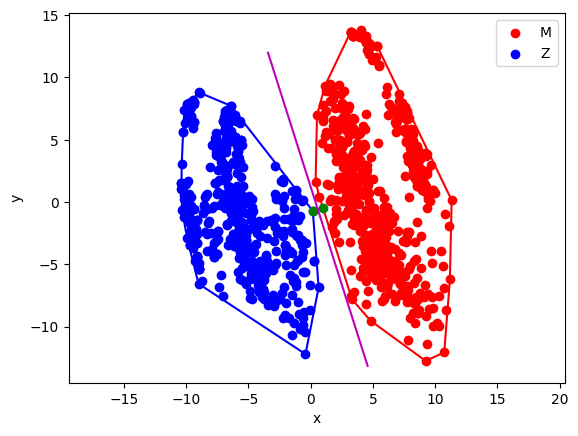

              x         y Class Predicted Class
1439   6.570170 -5.792353     M               M
76     4.461190 -0.107129     M               M
1010 -10.163170  0.209434     Z               Z
660   -5.286863 -2.110333     Z               Z
1132   5.878584 -3.260747     M               M

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: M

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: Z

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'Class'

labels = ['M', 'Z']

test_dataset(class_column, labels, df, 4)

# Movement Libras


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/movement_libras.csv"
df = pd.read_csv(url)

df['Class'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Classes: [1, 13]


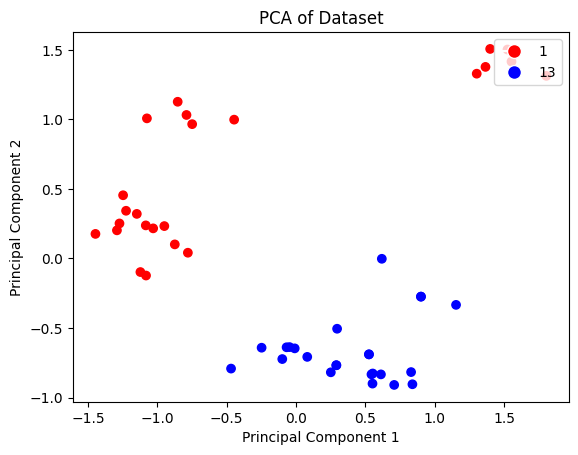

As classes são separáveis linearmente.

Equação da reta perpendicular: y = 0.4055319385602861x + -0.12171079655159295


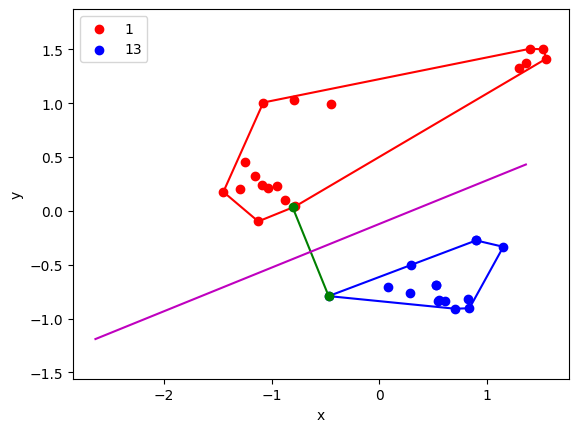

           x         y  Class  Predicted Class
27  0.618599 -0.002299     13               13
40 -0.009883 -0.646248     13               13
26  0.250657 -0.818309     13               13
43  0.290450 -0.767464     13               13
24 -0.099590 -0.723076     13               13

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 13

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



In [ ]:
class_column = 'Class'

labels = [1, 13]

test_dataset(class_column, labels, df, 2)

# Wine

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
df['target'].unique()

array([0, 1, 2])

Classes: [0, 1]


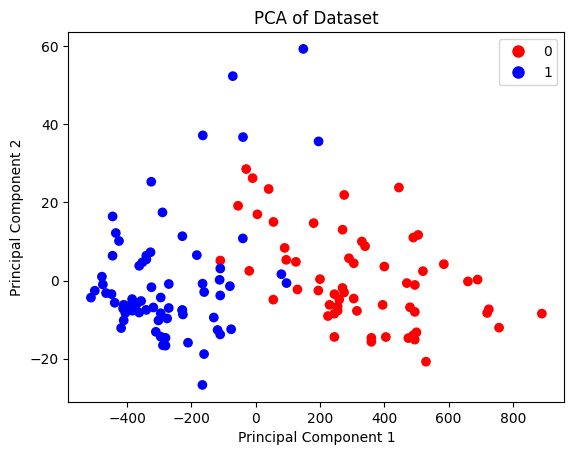

As classes não são separáveis linearmente.


In [ ]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, df, 3)

# Breast Cancer

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
df['target'].unique()

array([0, 1])

Classes: [0, 1]


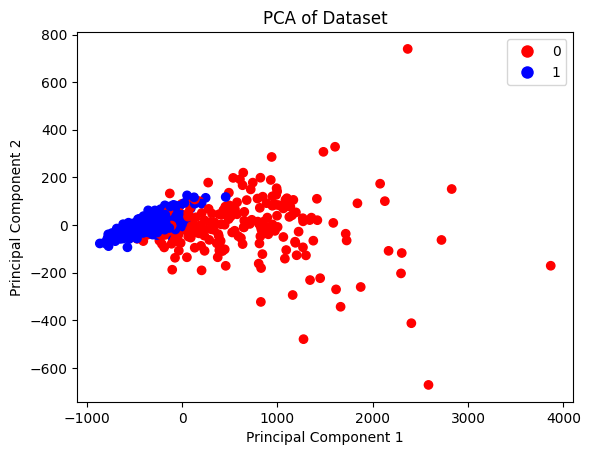

As classes não são separáveis linearmente.


In [ ]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, df, 3)